# Logistic Regression for df_merged_zero_15x15_final

# Table of Contents<a class="anchor" id="Contents"></a>
* [Load Packages](#Packages)
* [Load Dataset](#Dataset)
    * [Train Test Validation Split](#Train_Test_Validation_Split)
* [Functions](#Functions)
* [Logistic Regression](#LG)
    * [Run the Model](#Run_LG)
    * [ROC Curve and Precision-Recall Curve](#Curve_LG)
    * [Results](#Results_LG)
* [Logistic Regression with PCA](#PCA)

# Load Packages<a class="anchor" id="Packages"></a>

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.metrics import RocCurveDisplay, auc, roc_auc_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.metrics import silhouette_score
from keras.optimizers import Adam
import random
import csv
import statistics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [2]:
from joblib import load

best_lg = load('best_model/best_lg_mean.joblib')
best_lg_pc = load('best_model/best_lg_mean_pc.joblib')

* [Table of Contents](#Contents)

# Load Dataset<a class="anchor" id="Dataset"></a>

In [26]:
df_merged_mean_15x15 = pd.read_csv('data/df_merged_zero_15x15_final.csv')
df_merged_mean_15x15

,time,site,BBP_1x1_median,CDM_1x1_median,SPM_1x1_median,KD490_1x1_median,ZSD_1x1_median,CHL_1x1_median,BBP_1x1_mean,CDM_1x1_mean,...,KD490_15x15_q1,ZSD_15x15_q1,CHL_15x15_q1,BBP_15x15_q3,CDM_15x15_q3,SPM_15x15_q3,KD490_15x15_q3,ZSD_15x15_q3,CHL_15x15_q3,riskLevelLabel
0,2020-01-22,ukd4305-43260,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1
1,2020-02-17,ukk3106-27200,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1
2,2020-02-29,ukk4304-34200,0.0,0.0,0.206118,0.173157,0.127656,0.066746,0.0,0.0,...,0.185487,0.127656,0.073864,0.0,0.0,0.206118,0.177503,0.127656,0.069289,1
3,2020-03-01,ukk4305-25400,0.0,0.0,0.097241,0.098771,0.247233,0.026437,0.0,0.0,...,0.105168,0.243885,0.028865,0.0,0.0,0.097241,0.101709,0.247233,0.027571,1
4,2020-03-12,uke1200-08100,0.0,0.0,0.163267,0.201963,0.107813,0.085368,0.0,0.0,...,0.216346,0.107813,0.094473,0.0,0.0,0.163267,0.207033,0.107813,0.088622,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187106,2022-11-08,ukj3400-17700,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0
187107,2022-12-02,ukk3103-29500,0.0,0.0,0.029326,0.058402,0.482674,0.010515,0.0,0.0,...,0.062560,0.482674,0.011637,0.0,0.0,0.029326,0.059867,0.482674,0.010916,1
187108,2022-12-07,ukk3103-29100,0.0,0.0,0.022588,0.178036,0.150990,0.075031,0.0,0.0,...,0.156235,0.137526,0.055946,0.0,0.0,0.018829,0.182504,0.155471,0.077890,1
187109,2022-12-08,ukk3103-29100,0.0,0.0,0.017684,0.076698,0.330753,0.016954,0.0,0.0,...,0.081440,0.329495,0.018444,0.0,0.0,0.016590,0.078670,0.333127,0.017600,0


In [4]:
counts_normalized = df_merged_mean_15x15['riskLevelLabel'].value_counts(normalize=True)
counts_normalized

0    0.971797
1    0.028203
Name: riskLevelLabel, dtype: float64

## Train Test Validation Split<a class="anchor" id="Train_Test_Validation_Split"></a>

In [5]:
train_labels_mean_zero = pd.read_csv('data/train_labels_mean_zero.csv')[['time', 'site']]
train_labels_mean_zero

,time,site
0,2021-05-25,ukk4305-25800
1,2022-07-04,ukk4305-25800
2,2022-08-08,ukk3105-31450
3,2022-08-27,ukk2206-20800
4,2020-06-08,uke1301-09020
...,...,...
112261,2021-07-19,ukj4210-12660
112262,2021-05-10,ukk4200-23200
112263,2020-08-10,ukk3104-33500
112264,2021-09-08,ukk1202-35700


In [6]:
validation_labels_mean_zero = pd.read_csv('data/validation_labels_mean_zero.csv')[['time', 'site']]
validation_labels_mean_zero

,time,site
0,2020-07-02,ukj3400-17400
1,2022-08-27,ukk3106-32200
2,2021-05-06,ukk4307-33900
3,2021-05-20,ukk4304-34100
4,2021-06-04,ukk3104-33200
...,...,...
37417,2021-07-28,ukk3103-29800
37418,2021-05-02,uke2206-07200
37419,2022-09-08,ukk4301-21800
37420,2021-07-18,ukj2403-15900


In [27]:
test_labels_mean_zero = pd.read_csv('data/test_labels_mean_zero.csv')[['time', 'site']]
test_labels_mean_zero

,time,site
0,2022-09-21,ukk3106-32100
1,2020-08-08,ukh1407-10750
2,2020-09-20,ukd4200-42100
3,2022-07-06,ukk2206-20900
4,2021-08-24,ukk4305-26100
...,...,...
37418,2021-09-22,ukj2402-15680
37419,2021-08-14,ukk3104-33500
37420,2022-05-20,ukk4305-25600
37421,2022-06-25,ukj3400-18000


In [28]:
# Train test validation split
df_train = df_merged_mean_15x15.merge(train_labels_mean_zero, on=['time', 'site'], how='inner')
df_val = df_merged_mean_15x15.merge(validation_labels_mean_zero, on=['time', 'site'], how='inner')
df_test = df_merged_mean_15x15.merge(test_labels_mean_zero, on=['time', 'site'], how='inner')

df_train.drop(['time', 'site'], axis=1, inplace=True)
df_val.drop(['time', 'site'], axis=1, inplace=True)
df_test.drop(['time', 'site'], axis=1, inplace=True)

y_train = df_train.pop('riskLevelLabel')
y_val = df_val.pop('riskLevelLabel')
y_test = df_test.pop('riskLevelLabel')

X_train = df_train
X_val = df_val
X_test = df_test

print('Training X Shape:', X_train.shape)
print('Training y Shape:', y_train.shape)
print('Validation X Shape:', X_val.shape)
print('Validation y Shape:', y_val.shape)
print('Testing X Shape:', X_test.shape)
print('Testing y Shape:', y_test.shape)

Training X Shape: (112266, 192)
Training y Shape: (112266,)
Validation X Shape: (37422, 192)
Validation y Shape: (37422,)
Testing X Shape: (37423, 192)
Testing y Shape: (37423,)


* [Table of Contents](#Contents)

# Functions<a class="anchor" id="Functions"></a>

In [15]:
def pr_curve(model, X_test, y_test):
    y_pred = model.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    prc_auc = auc(recall, precision)
    fig, ax = plt.subplots()
    ax.plot(recall, precision, label='Precision recall curve (area = %0.2f)' % prc_auc)
    ax.axhline(y=counts_normalized[1], color='gray', linestyle='--', label='baseline')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend(loc="lower right")
    plt.show()
    return fig

In [16]:
def plot_roc(model, X_test, y_test):
    y_pred = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Curve')
    ax.legend(loc="lower right")
    plt.show()
    return fig

In [17]:
def cm(model,X_test,y_test):
    cm = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    cm.plot

In [13]:
def save_result(model,X_test,y_test):
    y_pred = model.predict(X_test)
    ACC = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    AUC_ROC = auc(fpr, tpr)
    PRE = precision_score(y_test, y_pred)
    REC = recall_score(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    AUC_PRC = auc(recall, precision)
    F1 = f1_score(y_test, y_pred)
    return ACC, AUC_ROC, PRE, REC, AUC_PRC, F1

In [9]:
def get_metrics_from_test_df(df):
    y_pred = df['predictions']
    y_actual = df['riskLevelLabel']

    f1_ = round(f1_score(y_actual, y_pred), 3)
    precision = round(precision_score(y_actual, y_pred), 3)
    recall = round(recall_score(y_actual, y_pred), 3)
    pr_auc = round(average_precision_score(y_actual, y_pred), 3)
    roc_auc = round(roc_auc_score(y_actual, y_pred), 3)   
    accuracy = round(accuracy_score(y_actual, y_pred), 3)
    
    metrics_list = [len(df), f1_, precision, recall, pr_auc, roc_auc, accuracy]
    return metrics_list

* [Table of Contents](#Contents)

# Logistic Regression<a class="anchor" id="LG"></a>

In [14]:
def lg_model(X_train, y_train, X_val, y_val):
    params = {'penalty': ['l1', 'l2', 'elasticnet'], # regularization types
              'C': [0.001, 0.01, 0.1, 1, 10], # λ
              'l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9]  # only relevant for 'elasticnet'
             }
    best_f1 = 0
    best_params = {}
    for penalty in params['penalty']:
        if penalty == 'elasticnet':
            for C in params['C']:
                for l1_ratio in params['l1_ratio']:
                    lg = LogisticRegression(C=C, penalty=penalty, l1_ratio=l1_ratio, 
                                           random_state = 100, #specify the random_state
                                           solver = 'saga', class_weight = 'balanced',
                                           n_jobs = -1, #use all cpu cores
                                           max_iter = 5000 #give more iteration for model to converge
                                           )
                    temp_model = lg.fit(X_train, y_train)
                    y_val_pred = lg.predict(X_val)
                    f1 = f1_score(y_val, y_val_pred)
                    if f1 > best_f1:
                        best_f1 = f1
                        best_params = {'penalty': penalty, 'C': C, 'l1_ratio': l1_ratio}
                        best_lg = temp_model
                        
        for C in params['C']:
            lg = LogisticRegression(C=C, penalty=penalty, random_state = 100, #specify the random_state
                                   solver = 'saga', class_weight = 'balanced', n_jobs = -1, #use all cpu cores
                                   max_iter = 5000 #give more iteration for model to converge
                                   )
            temp_model = lg.fit(X_train, y_train)
            y_val_pred = lg.predict(X_val)
            f1 = f1_score(y_val, y_val_pred)
            if f1 > best_f1:
                best_f1 = f1
                best_params = {'penalty': penalty, 'C': C}
                best_lg = temp_model
        
    print('Best Hyperparameters:', best_params)
    return best_lg

## Run the Model<a class="anchor" id="Run_LG"></a>

### Select the best hyperparameter on validation data

In [1]:
best_lg = lg_model(X_train, y_train, X_val, y_val)

Best Hyperparameters: {'penalty': 'elasticnet', 'C': 0.01, 'l1_ratio': 0.25}


## ROC Curve and Precision-Recall Curve<a class="anchor" id="Curve_LG"></a>

### ROC Curve

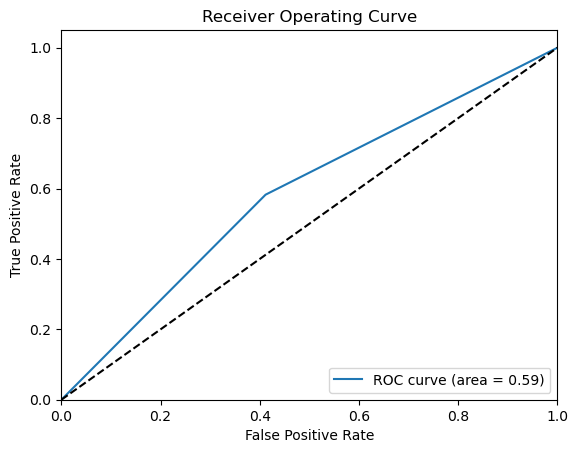

In [150]:
roc_lg = plot_roc(best_lg, X_test, y_test)

### Precision-Recall Curve

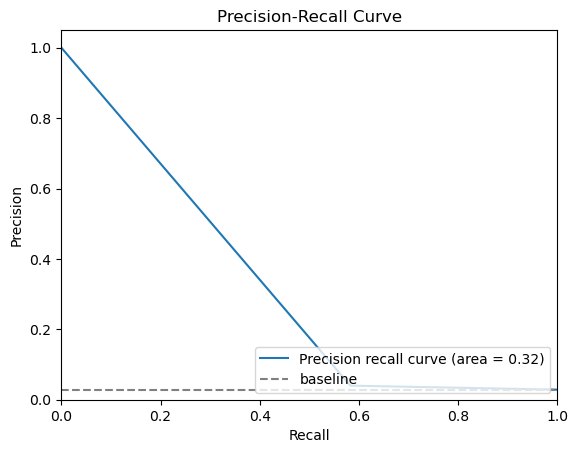

In [152]:
prc_lg = pr_curve(best_lg, X_test, y_test)

## Results<a class="anchor" id="Results_LG"></a>

LogisticRegression(C=0.01, class_weight='balanced', l1_ratio=0.1,
                   max_iter=10000, n_jobs=-1, penalty='elasticnet',
                   random_state=100, solver='saga') 
On test data, Accuracy: 0.59
On test data, Precision: 0.04
On test data, Recall: 0.58
On test data, f1 score: 0.07 


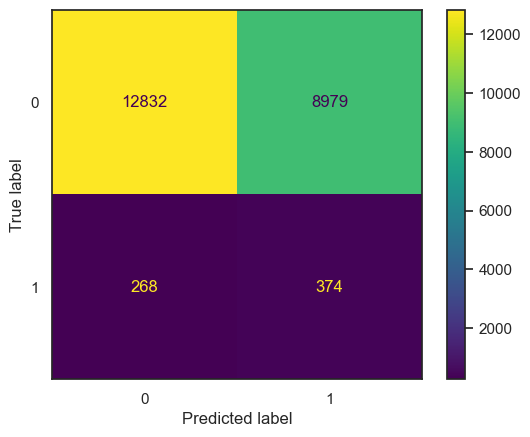

In [204]:
cm(best_lg, X_test, y_test)

In [108]:
results_df_lg = pd.DataFrame([['Logistic Regression', 'df_merged_mean_15x15', *save_result(best_lg,X_test,y_test)]],
                             columns=['Model', 'Sub-Model', 'Accuracy', 'AUC_ROC','Precision','Recall', 'AUC_PRC', 'f1 score'])
results_df_lg

,Model,Sub-Model,Accuracy,AUC_ROC,Precision,Recall,AUC_PRC,f1 score
0,Logistic Regression,df_merged_mean_15x15,0.588162,0.585441,0.039987,0.582555,0.317239,0.074837


* [Table of Contents](#Contents)

# Logistic Regression with PCA

In [19]:
## Fit X_train, X_val, X_test with the PCA
pca = PCA(n_components = 5, random_state = 100)
pca.fit(X_train)
X_train_pc = pca.transform(X_train)
X_val_pc = pca.transform(X_val)
X_test_pc = pca.transform(X_test)
print('the shape of X_train after PCA:',X_train_pc.shape,'the shape of y train:',y_train.shape)
print('the shape of X_val after PCA:',X_val_pc.shape,'the shape of y train:',y_val.shape)
print('the shape of X_test after PCA:',X_test_pc.shape,'the shape of y test:',y_test.shape)

the shape of X_train after PCA: (112266, 5) the shape of y train: (112266,)
the shape of X_val after PCA: (37422, 5) the shape of y train: (37422,)
the shape of X_test after PCA: (37423, 5) the shape of y test: (37423,)


In [20]:
%%time
best_lg_pc = lg_model(X_train_pc, y_train, X_val_pc, y_val)

Best Hyperparameters: {'penalty': 'elasticnet', 'C': 0.01, 'l1_ratio': 0.9}
Wall time: 29.4 s


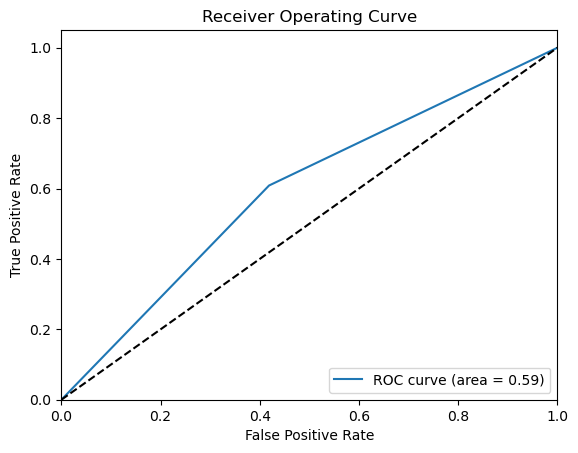

In [21]:
roc_lg = plot_roc(best_lg_pc, X_test_pc, y_test)

In [28]:
roc_lg.savefig('results/ROC_mean_15x15_lg_PCA.png')

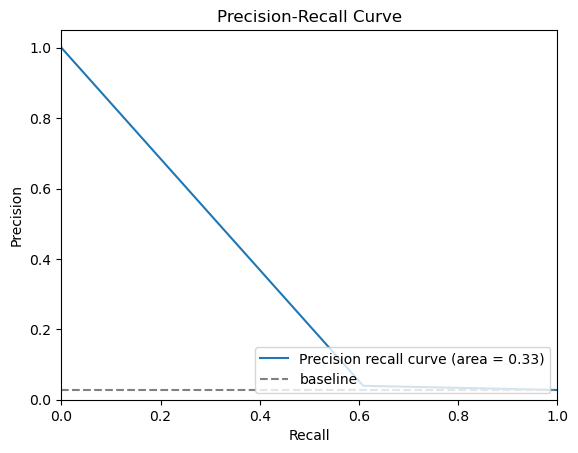

In [23]:
prc_lg = pr_curve(best_lg_pc, X_test_pc, y_test)

In [29]:
prc_lg.savefig('results/PRC_mean_15x15_lg_PCA.png')

LogisticRegression(C=0.01, class_weight='balanced', l1_ratio=0.9,
                   max_iter=10000, n_jobs=-1, penalty='elasticnet',
                   random_state=100, solver='saga') 
On test data, Accuracy: 0.58
On test data, Precision: 0.04
On test data, Recall: 0.61
On test data, f1 score: 0.07 


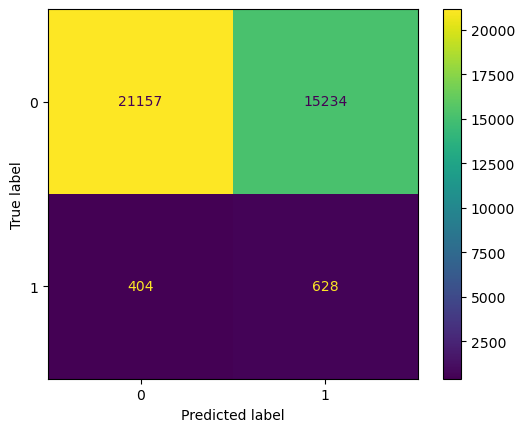

In [25]:
cm(best_lg_pc, X_test_pc, y_test)

In [26]:
results_df_lg = pd.DataFrame([['Logistic Regression', 'df_merged_mean_15x15', *save_result(best_lg_pc,X_test_pc,y_test)]],
                             columns=['Model', 'Sub-Model', 'Accuracy', 'AUC_ROC','Precision','Recall', 'AUC_PRC', 'f1 score'])
results_df_lg

,Model,Sub-Model,Accuracy,AUC_ROC,Precision,Recall,AUC_PRC,f1 score
0,Logistic Regression,df_merged_mean_15x15,0.582129,0.594954,0.039591,0.608527,0.329457,0.074346


In [27]:
results_df_lg.to_csv('results/results_mean_15x15_lg_PCA.csv')

# Test data for different regions

In [10]:
df_test_region = pd.read_csv('data/df_test_with_region.csv')

In [54]:
y_test_ld.value_counts(normalize=True)

0    0.959538
1    0.040462
Name: riskLevelLabel, dtype: float64

In [11]:
df_test_sw = df_test_region[df_test_region['region']=='South West']
df_test_sw = df_test_sw.drop(columns=['region', 'time', 'site'], axis=1)
y_test_sw = df_test_sw.pop('riskLevelLabel')
X_test_sw = df_test_sw
df_test_se = df_test_region[df_test_region['region']=='South East']
df_test_se = df_test_se.drop(columns=['region', 'time', 'site'], axis=1)
y_test_se = df_test_se.pop('riskLevelLabel')
X_test_se = df_test_se
df_test_ee = df_test_region[df_test_region['region']=='East of England']
df_test_ee = df_test_ee.drop(columns=['region', 'time', 'site'], axis=1)
y_test_ee = df_test_ee.pop('riskLevelLabel')
X_test_ee = df_test_ee
df_test_ne = df_test_region[df_test_region['region']=='North East']
df_test_ne = df_test_ne.drop(columns=['region', 'time', 'site'], axis=1)
y_test_ne = df_test_ne.pop('riskLevelLabel')
X_test_ne = df_test_ne
df_test_nw = df_test_region[df_test_region['region']=='North West']
df_test_nw = df_test_nw.drop(columns=['region', 'time', 'site'], axis=1)
y_test_nw = df_test_nw.pop('riskLevelLabel')
X_test_nw = df_test_nw
df_test_yh = df_test_region[df_test_region['region']=='Yorkshire and The Humber']
df_test_yh = df_test_yh.drop(columns=['region', 'time', 'site'], axis=1)
y_test_yh = df_test_yh.pop('riskLevelLabel')
X_test_yh = df_test_yh
df_test_em = df_test_region[df_test_region['region']=='East Midlands']
df_test_em = df_test_em.drop(columns=['region', 'time', 'site'], axis=1)
y_test_em = df_test_em.pop('riskLevelLabel')
X_test_em = df_test_em

In [52]:
df_test_ld = df_test_region[df_test_region['region']=='London']
df_test_ld = df_test_ld.drop(columns=['region', 'time', 'site'], axis=1)
y_test_ld = df_test_ld.pop('riskLevelLabel')
X_test_ld = df_test_ld

In [53]:
results_df_lg_regions = pd.DataFrame([['Logistic Regression', 'df_merged_zero_15x15', 'South West', *save_result(best_lg,X_test_sw,y_test_sw)],
                                  ['','', 'South East', *save_result(best_lg,X_test_se,y_test_se)], 
                                 ['','', 'East of England', *save_result(best_lg,X_test_ee,y_test_ee)], 
                                 ['','', 'North East', *save_result(best_lg,X_test_ne,y_test_ne)], 
                                 ['','', 'North West', *save_result(best_lg,X_test_nw,y_test_nw)], 
                                 ['','', 'Yorkshire and The Humber', *save_result(best_lg,X_test_yh,y_test_yh)],
                                 ['','', 'East Midlands', *save_result(best_lg,X_test_em,y_test_em)], 
                                  ['','', 'London', *save_result(best_lg,X_test_ld,y_test_ld)]],
                             columns=['Model', 'Sub-Model', 'Region', 'Accuracy', 'AUC_ROC','Precision','Recall', 'AUC_PRC', 'f1 score'])
results_df_lg_regions

,Model,Sub-Model,Region,Accuracy,AUC_ROC,Precision,Recall,AUC_PRC,f1 score
0,Logistic Regression,df_merged_zero_15x15,South West,0.623229,0.598928,0.037249,0.573363,0.310578,0.069953
1,,,South East,0.632908,0.643574,0.045231,0.654822,0.354499,0.084618
2,,,East of England,0.454416,0.503193,0.018730,0.553846,0.290419,0.036236
3,,,North East,0.590586,0.651950,0.052842,0.717391,0.389519,0.098434
4,,,North West,0.497849,0.551221,0.060929,0.610687,0.345781,0.110803
5,,,Yorkshire and The Humber,0.539301,0.534150,0.043632,0.528571,0.295108,0.080610
6,,,East Midlands,0.452586,0.499852,0.028721,0.550000,0.295826,0.054591
7,,,London,0.040462,0.500000,0.040462,1.000000,0.520231,0.077778


In [55]:
results_df_lg_regions.to_csv('results/15_mean_LG/Regions_zero_results.csv', index=False)

# Test data for different months

In [32]:
df_test = df_merged_mean_15x15.merge(test_labels_mean_zero, on=['time', 'site'], how='inner')
df_test['predictions'] = best_lg.predict(X_test)

In [33]:
df_test['time'] = pd.to_datetime(df_test['time'])

In [21]:
df_test_may = get_metrics_from_test_df(df_test[df_test['time'].dt.month==5])
df_test_jun = get_metrics_from_test_df(df_test[df_test['time'].dt.month==6])
df_test_jul = get_metrics_from_test_df(df_test[df_test['time'].dt.month==7])
df_test_aug = get_metrics_from_test_df(df_test[df_test['time'].dt.month==8])
df_test_sep = get_metrics_from_test_df(df_test[df_test['time'].dt.month==9])

In [22]:
print(df_test_may)
print(df_test_jun)
print(df_test_jul)
print(df_test_aug)
print(df_test_sep)

[6430, 0.045, 0.024, 0.636, 0.021, 0.612, 0.588]
[7690, 0.058, 0.031, 0.635, 0.027, 0.605, 0.577]
[7829, 0.059, 0.031, 0.645, 0.027, 0.619, 0.595]
[7683, 0.093, 0.05, 0.592, 0.044, 0.598, 0.604]
[7429, 0.109, 0.06, 0.585, 0.054, 0.576, 0.569]


# Test data for different years

In [23]:
df_test_2020 = get_metrics_from_test_df(df_test[df_test['time'].dt.year==2020])
df_test_2021 = get_metrics_from_test_df(df_test[df_test['time'].dt.year==2021])
df_test_2022 = get_metrics_from_test_df(df_test[df_test['time'].dt.year==2022])

In [24]:
print(df_test_2020)
print(df_test_2021)
print(df_test_2022)

[11766, 0.08, 0.043, 0.628, 0.038, 0.59, 0.555]
[12894, 0.08, 0.043, 0.595, 0.038, 0.585, 0.575]
[12763, 0.063, 0.033, 0.599, 0.028, 0.612, 0.624]


In [44]:
# a = df_test[df_test['time'].dt.month==9]
# a['riskLevelLabel'].value_counts(normalize=True)